dataset website: https://janelia.figshare.com/articles/dataset/Towards_a_simplified_model_of_primary_visual_cortex/28797638/2

paper: Du, F. et al. (2025) “A simplified minimodel of visual cortical neurons,” Nature Communications, 16(1). Available at: https://doi.org/10.1038/s41467-025-61171-9.


Neural activity from 6 large-scale recordings from mouse primary visual cortex. Please see the paper and code repository (https://github.com/MouseLand/minimodel) for more details about the data acquisition and analysis.

Neural Recordings
The following data files contain the neural activity for training the model:

- FX8_nat60k_2023_05_16.npz
- FX9_nat60k_2023_05_15.npz
- FX10_nat60k_2023_05_16.npz
- FX20_nat60k_2023_09_29.npz
- L1_A1_nat60k_2023_03_06.npz
- L1_A5_nat60k_2023_02_27.npz

Each file contains the recordings of training and testing images from one mouse, and includes the following keys:

- ["sp"]: Shape (n_neurons, n_images), responses of each neuron to each image used for training and validating.
- ["istim_sp"]: Shape (n_images), indexes of the images in the image file, corresponding to the stimuli used in "sp".
- ["ss_all"]: Shape (n_test_images, n_repeats, n_neurons), responses of each neuron to each test image (500 images).
- ["istim_ss"]: Shape (n_test_images), indexes of the test images in the image file.
- ["xpos"]: Shape (n_neurons), x cortical position of each neuron.
- ["ypos"]: Shape (n_neurons), y cortical position of each neuron.
- ["iplane"]: Shape (n_neurons), imaging plane the neuron is from.

The following data files contain the neural activity for texture-invariance analysis:

- text16_FX8_2023_05_16.npz
- text16_FX9_2023_05_15.npz
- text16_FX10_2023_05_16.npz
- text16_FX20_2023_09_29.npz

Each file contains the recordings of texture images from 16 categories from one mouse, and includes the following keys:

- ["sp"]: Shape (n_neurons, n_images), responses of each neuron to each image. Includes 4800 images, with 300 images from each of the 16 texture categories used for training the classifier. Contains the same number of neurons as the neural recordings for model training.
- ["istim_sp"]: Shape (n_images), indexes of the images in the image file, corresponding to the stimuli used in "sp".
- ["labels"]: Shape (n_images), label of the category each image belongs to.
- ["ss_all"]: Shape (n_test_images, n_repeats, n_neurons), responses of each neuron to each test image (50 images per category).
- ["istim_ss"]: Shape (n_test_images), label of the category each test image belongs to.
- ["ss_labels"]: Shape (n_test_images), indexes of the test images in the image file.
- ["xpos"]: Shape (n_neurons), x cortical position of each neuron.
- ["ypos"]: Shape (n_neurons), y cortical position of each neuron.

Image File

- nat60k_text16.mat: Contains images with shape (66, 264, 68000), including 30,000 nature images and their flipped versions used for model training, and 8000 texture images for texture-invariance analysis. Each image has a shape of (66, 264).

Funding

HHMI Janelia Research Campus

History

2025-04-19 - First online date

2025-04-30 - Posted date

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import cv2

data_path = './'

In [2]:
filelist = os.listdir(data_path)
nat60k_files = [f for f in filelist if f.endswith('.npz') and 'nat60k' in f]
text16_files = [f for f in filelist if f.endswith('.npz') and 'text16' in f]

Nautral Textural Data

In [3]:
nat60k_1s = np.load(os.path.join(data_path, nat60k_files[0]))
print('Files of nat60k_1s:', nat60k_1s.files)
neuresp = nat60k_1s['sp']
istim_sp = nat60k_1s['istim_sp'].astype(int)
print('neuresp shape:', neuresp.shape)

Files of nat60k_1s: ['sp', 'xpos', 'ypos', 'iplane', 'ss', 'istim_sp', 'istim_ss', 'ss_all']
neuresp shape: (5804, 36539)


Dict key of stim_all: dict_keys(['__header__', '__version__', '__globals__', 'img', 'istim', 'iorig'])
img file shape: (66, 264, 68000)


Text(0.5, 1.0, 'Example image')

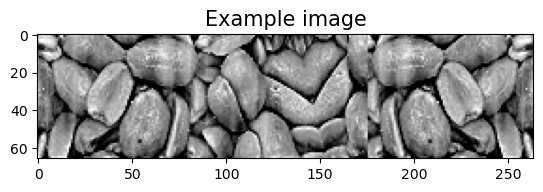

In [4]:
stim_all = loadmat(os.path.join(data_path, f'nat60k_text16.mat'))
print('Dict key of stim_all:', stim_all.keys())
print('img file shape:', stim_all['img'].shape)
plt.imshow((stim_all['img'][:,:,60000]), cmap='gray')
plt.title('Example image', fontsize = 15)

In [5]:
stim_sp = stim_all['img'][:,:,istim_sp] # stimulus for neural response
print('stim_sp shape (H, W, N): ', stim_sp.shape)

stim_sp shape (H, W, N):  (66, 264, 36539)


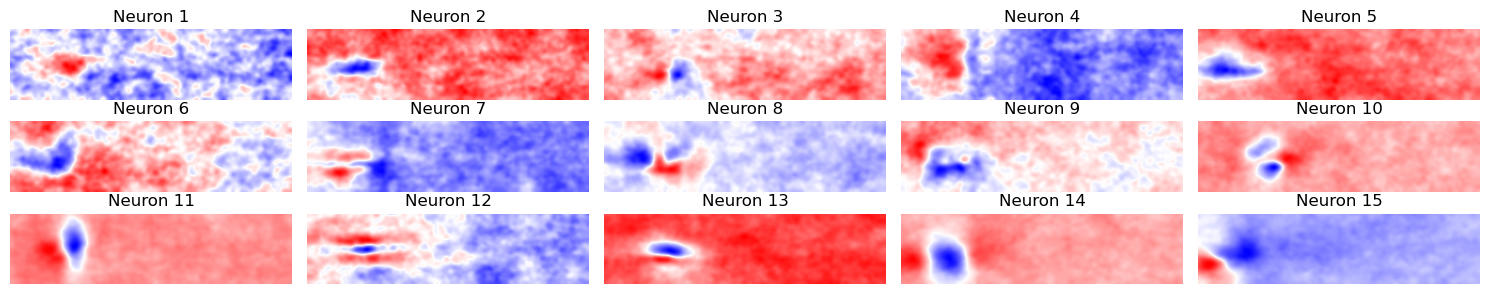

In [ ]:
# use STA to estimate the receptive field
stimulus = stim_all['img'][:,:,istim_sp]
n_cols = 5
n_rows = 3

neuron_indices = np.arange(n_cols * n_rows)
responses = neuresp[neuron_indices]  # shape: (n_neuron, n_image)

# normalize the response
responses = (responses - responses.mean(axis=1, keepdims=True)) / responses.std(axis=1, keepdims=True)

# compute RF: stimulus (H, W, N), responses (n_neuron, N)
# weighted sum for each neuron
weighted_stimulus = np.tensordot(stimulus, responses, axes=([2], [1]))  # (H, W, n_neuron)
stimulus_sum = np.sum(stimulus, axis=2, keepdims=True)  # (H, W, 1)
receptive_fields = weighted_stimulus / (stimulus_sum + 1e-8)  # (H, W, n_neuron)

plt.figure(figsize=(n_cols * 3, n_rows * 1))
for i, idx in enumerate(neuron_indices):
    plt.subplot(n_rows, n_cols, i + 1)
    rf_img = cv2.GaussianBlur(receptive_fields[:, :, i], (5, 5), 2)
    plt.imshow(rf_img, cmap='bwr')
    plt.axis('off')
    plt.title(f"Neuron {idx+1}")
plt.tight_layout()
plt.show()